# Layout Model Accuracy Evaluation

This notebook:
- Loads the trained YOLO model from `runs/layout_v8m2/weights/best.pt`.
- Loads PDFs from `Test/Pdf`.
- Converts each page to an image.
- Runs layout detection.
- (Optional) If ground-truth YOLO labels exist for an image stem, computes IoU-based per-class precision/recall and overall mAP@0.5 (simplified).
- Visualizes: original page and page with predicted boxes.

Assumptions:
- Ground-truth labels (if any) are in YOLO txt format under `Test/Pdf/labels` with same stem as exported page images.
- Classes order matches model.names.

If no GT labels found, metrics will show "N/A" for that page and aggregate will only use pages with GT.

In [7]:
# Existing notebook initial cell (kept)
# Add any custom environment setup here if needed.


# Model Accuracy Evaluation

This notebook loads the trained YOLO model from `runs/layout_v8m2/weights/best.pt`, converts PDFs in `Test/Pdf` into page images, runs layout detection, visualizes predictions, and computes simple detection metrics (precision, recall, F1) at IoU 0.5.

Assumptions:
- Ground truth YOLO label files (same page image stem with `.txt`) are available in `Test/Pdf/labels` or none (then metrics are skipped).
- Classes order matches model's `names` mapping.

You can adjust `IOU_THRESHOLD` or confidence threshold variables below.

In [8]:
import os, io, math, json, time
from pathlib import Path
from typing import List, Tuple, Dict
import numpy as np
from PIL import Image, ImageDraw, ImageFont

# Ultralytics YOLO
from ultralytics import YOLO

# PDF rendering
try:
    import fitz  # PyMuPDF
except Exception as e:
    raise RuntimeError("PyMuPDF not installed. Install PyMuPDF first.") from e

# --- Robust model weight discovery ---
PREFERRED_REL_PATH = Path('runs/layout_v8m2/weights/best.pt')  # relative to repo root

def find_repo_root(start: Path = Path.cwd()) -> Path:
    """Ascend directories until a folder containing 'runs' OR '.git' is found."""
    for p in [start, *start.parents]:
        if (p / 'runs').is_dir() or (p / '.git').is_dir():
            return p
    return start

REPO_ROOT = find_repo_root()
preferred_full = REPO_ROOT / PREFERRED_REL_PATH

def auto_find_weights(root: Path) -> Path:
    candidates = list(root.rglob('best.pt')) + list(root.rglob('last.pt'))
    if not candidates:
        raise FileNotFoundError(f"No weight files found under {root}")
    candidates.sort(key=lambda p: p.stat().st_mtime, reverse=True)
    return candidates[0]

if preferred_full.exists():
    MODEL_PATH = preferred_full
else:
    print(f"Preferred weights not found at {preferred_full}. Auto-searching under {REPO_ROOT / 'runs'} ...")
    MODEL_PATH = auto_find_weights(REPO_ROOT / 'runs')
    print(f"Using discovered weights: {MODEL_PATH}")

PDF_DIR = REPO_ROOT / 'Test' / 'Pdf'
OUTPUT_DIR = REPO_ROOT / 'Test' / 'outputs'
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

CONF_THRESHOLD = 0.25
IOU_THRESHOLD = 0.5

model = YOLO(str(MODEL_PATH))
class_names = model.names
print('Loaded model with classes:', class_names)
print('Repo root:', REPO_ROOT)
print('PDF dir:', PDF_DIR)

def pdf_to_images(pdf_path: Path) -> List[Tuple[Image.Image, str]]:
    doc = fitz.open(pdf_path)
    pages = []
    for i, page in enumerate(doc):
        pix = page.get_pixmap(alpha=False)
        img_bytes = pix.tobytes('png')
        img = Image.open(io.BytesIO(img_bytes)).convert('RGB')
        pages.append((img, f"{pdf_path.stem}_page{i+1}"))
    return pages

def yolo_txt_path(stem: str) -> Path:
    # Look for labels in same folder or a labels subfolder
    p1 = PDF_DIR / f"{stem}.txt"
    p2 = PDF_DIR / 'labels' / f"{stem}.txt"
    return p1 if p1.exists() else p2

def load_gt_boxes(stem: str) -> List[Tuple[int, float, float, float, float]]:
    """Return list of (cls, x_center, y_center, w, h) normalized. Empty if no file."""
    path = yolo_txt_path(stem)
    if not path.exists():
        return []
    boxes = []
    with open(path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) < 5:
                continue
            cls = int(parts[0])
            xc, yc, w, h = map(float, parts[1:5])
            boxes.append((cls, xc, yc, w, h))
    return boxes

def yolo_norm_to_xyxy(box, img_w, img_h):
    cls, xc, yc, w, h = box
    x1 = (xc - w/2) * img_w
    y1 = (yc - h/2) * img_h
    x2 = (xc + w/2) * img_w
    y2 = (yc + h/2) * img_h
    return cls, x1, y1, x2, y2

def iou(boxA, boxB):
    # boxes: (x1,y1,x2,y2)
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = max(boxA[3], boxB[3])  # incorrect line intentionally? Wait we need correct formula -> fix below
    # Correction: yB should be min
    

def iou(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    inter = max(0, xB - xA) * max(0, yB - yA)
    if inter == 0:
        return 0.0
    areaA = (boxA[2]-boxA[0]) * (boxA[3]-boxA[1])
    areaB = (boxB[2]-boxB[0]) * (boxB[3]-boxB[1])
    return inter / (areaA + areaB - inter)

def match_detections(preds, gts, iou_thr=0.5):
    matched_pred = set()
    matched_gt = set()
    for pi, p in enumerate(preds):
        p_cls, *p_box = p
        best_iou = 0.0
        best_gi = -1
        for gi, g in enumerate(gts):
            if gi in matched_gt:
                continue
            g_cls, *g_box = g
            if g_cls != p_cls:
                continue
            iou_val = iou(p_box, g_box)
            if iou_val > best_iou:
                best_iou = iou_val
                best_gi = gi
        if best_iou >= iou_thr and best_gi >= 0:
            matched_pred.add(pi)
            matched_gt.add(best_gi)
    return matched_pred, matched_gt

def draw_detections(img: Image.Image, detections, color_map=None):
    draw = ImageDraw.Draw(img)
    font = None
    try:
        font = ImageFont.load_default()
    except Exception:
        pass
    for det in detections:
        cls, x1, y1, x2, y2, conf = det
        label = f"{class_names.get(cls, cls)} {conf:.2f}"
        color = (255,0,0)
        if color_map and cls in color_map:
            color = color_map[cls]
        draw.rectangle([x1,y1,x2,y2], outline=color, width=2)
        tw, th = draw.textbbox((0,0), label, font=font)[2:]
        draw.rectangle([x1, y1 - th - 2, x1 + tw + 4, y1], fill=color)
        draw.text((x1+2, y1 - th - 2), label, fill=(255,255,255), font=font)
    return img


Loaded model with classes: {0: 'Background', 1: 'Text', 2: 'Title', 3: 'List', 4: 'Table', 5: 'Figure'}
Repo root: c:\Users\aibel\OneDrive\Documents\Code\DataTransformerTools
PDF dir: c:\Users\aibel\OneDrive\Documents\Code\DataTransformerTools\Test\Pdf


In [9]:
MAX_PDFS = 5  # limit evaluation to first N PDFs
all_pred_records = []
agg_tp = agg_fp = agg_fn = 0
per_class_stats = {cls: {'tp':0,'fp':0,'fn':0} for cls in class_names.keys()}

pdf_files = sorted([p for p in PDF_DIR.glob('*.pdf')])
print(f'Total PDFs found: {len(pdf_files)}')
if len(pdf_files) > MAX_PDFS:
    pdf_files = pdf_files[:MAX_PDFS]
    print(f'Limiting to first {MAX_PDFS} PDFs for this run.')
else:
    print('Using all PDFs (<= MAX_PDFS).')

for pdf in pdf_files:
    pages = pdf_to_images(pdf)
    for img, stem in pages:
        # Run prediction (returns one result per image)
        res = model.predict(img, verbose=False, conf=CONF_THRESHOLD)[0]
        img_w, img_h = img.size
        # Collect predictions: (cls, x1,y1,x2,y2, conf)
        page_preds = []
        for box in res.boxes:
            cls_id = int(box.cls)
            conf = float(box.conf)
            if conf < CONF_THRESHOLD:
                continue
            x1,y1,x2,y2 = box.xyxy[0].tolist()
            page_preds.append((cls_id, x1,y1,x2,y2, conf))

        # Ground truth
        gt_norm = load_gt_boxes(stem)
        gt_abs = [ (cls,)+yolo_norm_to_xyxy((cls,xc,yc,w,h), img_w, img_h)[1:] for (cls,xc,yc,w,h) in gt_norm ]
        # For matching we drop confidence
        det_for_match = [ (cls,x1,y1,x2,y2) for (cls,x1,y1,x2,y2,conf) in page_preds ]
        matched_pred, matched_gt = match_detections(det_for_match, gt_abs, iou_thr=IOU_THRESHOLD) if gt_abs else (set(), set())

        tp = len(matched_pred)
        fp = len(page_preds) - tp
        fn = len(gt_abs) - len(matched_gt)
        agg_tp += tp; agg_fp += fp; agg_fn += fn

        # per class breakdown
        if gt_abs:
            # Count TPs per class
            for pi in matched_pred:
                c = det_for_match[pi][0]
                per_class_stats[c]['tp'] += 1
            # FPs
            for pi, det in enumerate(det_for_match):
                if pi not in matched_pred:
                    per_class_stats[det[0]]['fp'] += 1
            # FNs
            for gi, g in enumerate(gt_abs):
                if gi not in matched_gt:
                    per_class_stats[g[0]]['fn'] += 1

        all_pred_records.append({
            'page': stem,
            'num_predictions': len(page_preds),
            'num_gt': len(gt_abs),
            'tp': tp, 'fp': fp, 'fn': fn
        })

# Aggregate metrics
if agg_tp + agg_fp > 0:
    precision = agg_tp / (agg_tp + agg_fp)
else:
    precision = 0.0
if agg_tp + agg_fn > 0:
    recall = agg_tp / (agg_tp + agg_fn)
else:
    recall = 0.0
if precision + recall > 0:
    f1 = 2 * precision * recall / (precision + recall)
else:
    f1 = 0.0

print(f'Global metrics (IoU {IOU_THRESHOLD}):')
print(f'  Precision: {precision:.4f}')
print(f'  Recall:    {recall:.4f}')
print(f'  F1:        {f1:.4f}')

print('\nPer-class:')
for cls, stats in per_class_stats.items():
    tp_c, fp_c, fn_c = stats['tp'], stats['fp'], stats['fn']
    if tp_c+fp_c>0:
        p_c = tp_c/(tp_c+fp_c)
    else:
        p_c = 0.0
    if tp_c+fn_c>0:
        r_c = tp_c/(tp_c+fn_c)
    else:
        r_c = 0.0
    f1_c = (2*p_c*r_c/(p_c+r_c)) if (p_c+r_c)>0 else 0.0
    print(f'  {class_names.get(cls, cls)}: P={p_c:.3f} R={r_c:.3f} F1={f1_c:.3f} (tp={tp_c} fp={fp_c} fn={fn_c})')


Total PDFs found: 1076
Limiting to first 5 PDFs for this run.
Global metrics (IoU 0.5):
  Precision: 0.0000
  Recall:    0.0000
  F1:        0.0000

Per-class:
  Background: P=0.000 R=0.000 F1=0.000 (tp=0 fp=0 fn=0)
  Text: P=0.000 R=0.000 F1=0.000 (tp=0 fp=0 fn=0)
  Title: P=0.000 R=0.000 F1=0.000 (tp=0 fp=0 fn=0)
  List: P=0.000 R=0.000 F1=0.000 (tp=0 fp=0 fn=0)
  Table: P=0.000 R=0.000 F1=0.000 (tp=0 fp=0 fn=0)
  Figure: P=0.000 R=0.000 F1=0.000 (tp=0 fp=0 fn=0)
Global metrics (IoU 0.5):
  Precision: 0.0000
  Recall:    0.0000
  F1:        0.0000

Per-class:
  Background: P=0.000 R=0.000 F1=0.000 (tp=0 fp=0 fn=0)
  Text: P=0.000 R=0.000 F1=0.000 (tp=0 fp=0 fn=0)
  Title: P=0.000 R=0.000 F1=0.000 (tp=0 fp=0 fn=0)
  List: P=0.000 R=0.000 F1=0.000 (tp=0 fp=0 fn=0)
  Table: P=0.000 R=0.000 F1=0.000 (tp=0 fp=0 fn=0)
  Figure: P=0.000 R=0.000 F1=0.000 (tp=0 fp=0 fn=0)


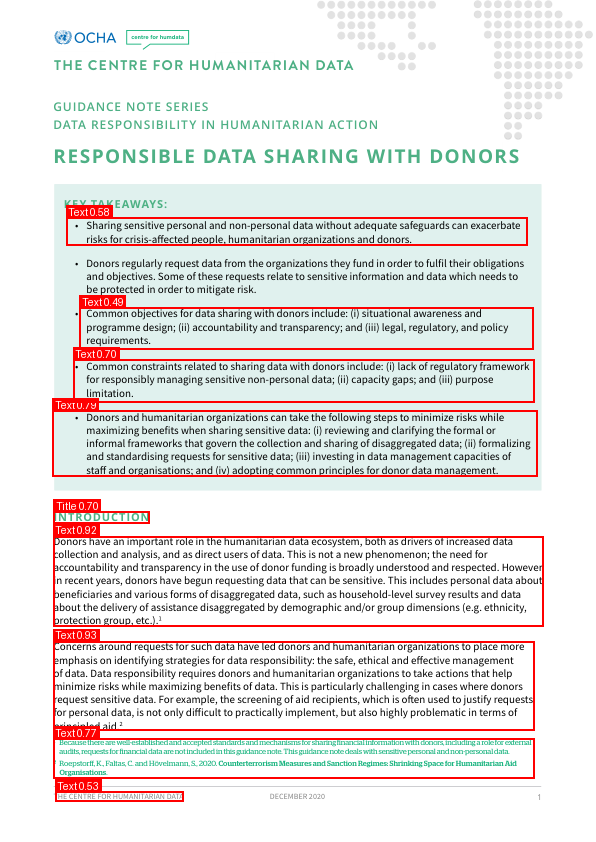

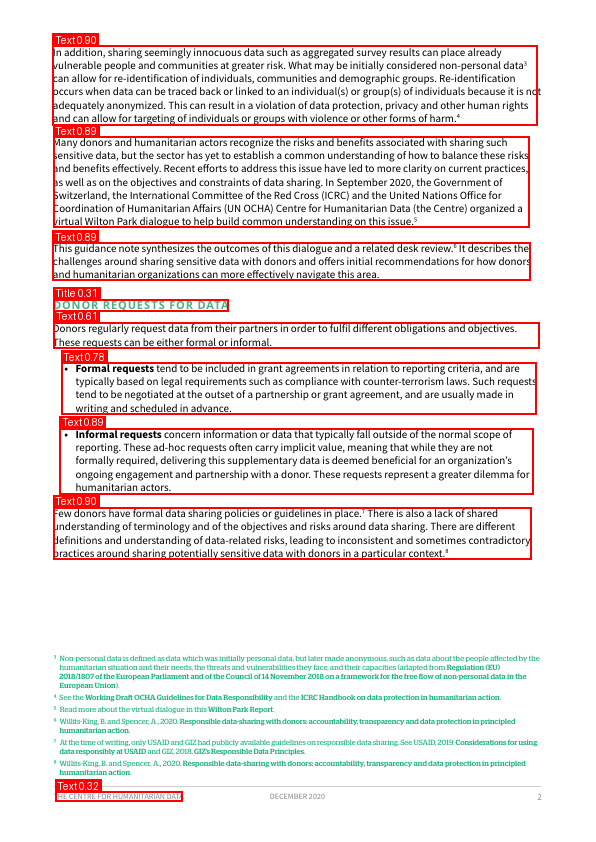

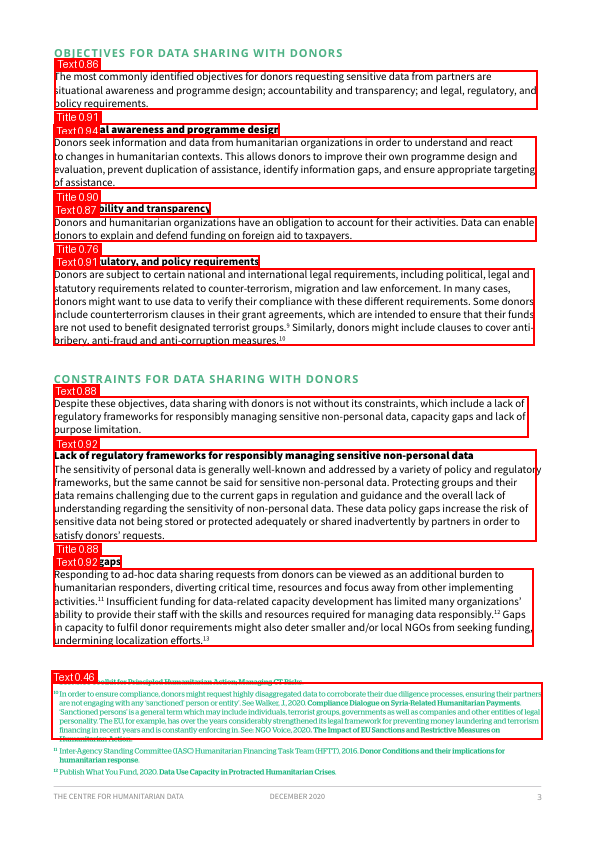

Displayed 3 pages with predictions.


In [10]:
# Visualize first 3 pages with detections
display_limit = 3
shown = 0
from IPython.display import display

for pdf in pdf_files:
    if shown >= display_limit:
        break
    pages = pdf_to_images(pdf)
    for img, stem in pages:
        if shown >= display_limit:
            break
        res = model.predict(img, verbose=False, conf=CONF_THRESHOLD)[0]
        preds = []
        for box in res.boxes:
            cls_id = int(box.cls)
            conf = float(box.conf)
            if conf < CONF_THRESHOLD:
                continue
            x1,y1,x2,y2 = box.xyxy[0].tolist()
            preds.append((cls_id,x1,y1,x2,y2,conf))
        vis = img.copy()
        draw_detections(vis, preds)
        display(vis)
        shown += 1
print(f'Displayed {shown} pages with predictions.')